In [1]:
# Global imports
import os
import numpy as np
import pandas as pd
import imageio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import tensorflow_addons as tfa
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from sklearn.model_selection import KFold
import numpy as np
import os
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, Flatten, Dense
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from tqdm import tqdm
import gc

c:\Users\herna\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\herna\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want

In [2]:
# import tensorflow as tf
# import librosa
# #print(tf.config.list_physical_devices('GPU'))
# # Desactivar GPU y forzar uso de CPU
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         #tf.config.experimental.set_memory_growth(gpus[0], True)
#         pass
#     except RuntimeError as e:
#         print(e)

# #tf.config.set_visible_devices([], 'GPU')

In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # TensorFlow 2.x
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU found")


1 Physical GPUs, 1 Logical GPUs


# Load dataset


In [4]:
import pickle
def load_data(filename):
    """
    Load data from a pickle file.

    Args:
        filename (str): The path to the pickle file.

    Returns:
        dict: The loaded data dictionary.
    """
    with open(filename, 'rb') as file:
        data_dict_loaded = pickle.load(file)
    return data_dict_loaded

filename = "../Data/D3TEC.pkl"
data_dict_loaded = load_data(filename)
# data_dict_loaded

In [5]:
#data_dict_loaded[3]

In [33]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, Flatten, Dense, Input, MaxPooling2D, Dropout, Resizing, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import StratifiedKFold
import datetime
import json
from tqdm import tqdm
from PIL import Image
import gc
import psutil
from sklearn.metrics import confusion_matrix
import torchaudio
import matplotlib.pyplot as plt
import io

# Deshabilitar XLA compilación
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'

# Ruta base para los archivos de espectrogramas
base_path = "F:\\Github\\Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search\\D3T3C"

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.cast((y_pred < 0.5) & (y_true == 0), tf.float32))
    possible_negatives = tf.reduce_sum(tf.cast(y_true == 0, tf.float32))
    specificity = true_negatives / (possible_negatives + tf.keras.backend.epsilon())
    return specificity

def log_memory_usage(stage):
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    print(f"[{stage}] Memory usage: {memory_info.rss / (1024 ** 2):.2f} MB")

class KFoldCNNTester:
    def __init__(self, data_dict, filename, batch_size=1, use_dummy_data=False, loading_method='tf_data', model_type='SpectroCNN', num_channels=3, recording_device='sm', num_folds=5, use_gender='All', reset_saves=False, image_size=(792, 293), max_segment_length=5):
        self.data_dict = data_dict
        self.filename = filename
        self.batch_size = batch_size
        self.mean_acc_per_fold = []
        self.mean_loss_per_fold = []
        self.mean_precision_per_fold = []
        self.mean_recall_per_fold = []
        self.mean_auc_per_fold = []
        self.mean_specificity_per_fold = []
        self.mean_f1_per_fold = []  # Para guardar los F1 Scores
        self.kfold_list = []
        self.state_file = f'{self.filename}_state.json'
        self.keys = list(data_dict.keys())  # Lista de keys del diccionario
        self.use_dummy_data = use_dummy_data
        self.loading_method = loading_method  # Método de carga de datos
        self.model_type = model_type  # Flag para elegir el modelo a utilizar
        self.num_channels = num_channels  # Número de canales para las imágenes
        self.recording_device = recording_device  # Tipo de dispositivo de grabación
        self.num_folds = num_folds  # Número de K-folds a correr
        self.use_gender = use_gender  # Género a utilizar en el K-fold
        self.reset_saves = reset_saves  # Flag para reiniciar los guardados
        self.image_size = image_size  # Tamaño de las imágenes generadas
        self.max_segment_length = max_segment_length  # Máxima longitud de los segmentos de audio en segundos

        if self.reset_saves and os.path.exists(self.state_file):
            os.remove(self.state_file)

    def save_state(self, fold_no, epoch_no, checkpoint_list, metrics_per_fold):
        state = self.load_state() or {}
        state.setdefault('model_type', {}).setdefault(self.model_type, {}).setdefault(self.use_gender, {})[str(self.num_folds)] = {
            'epoch': epoch_no,
            'checkpoints': checkpoint_list,
            'fold_no': fold_no,
            'metrics_per_fold': metrics_per_fold
        }
        with open(self.state_file, 'w') as f:
            json.dump(state, f)

    def load_state(self):
        if os.path.exists(self.state_file):
            with open(self.state_file, 'r') as f:
                state = json.load(f)
            return state
        return None

    def try_load_weights(self, model):
        state = self.load_state()
        if state is not None:
            if str(self.num_folds) not in state['model_type'][self.model_type][self.use_gender]:
                return state, 1, 0, []
            last_checkpoint_dict = state['model_type'][self.model_type][self.use_gender][str(self.num_folds)]
            checkpoints = last_checkpoint_dict['checkpoints']
            for checkpoint in reversed(checkpoints):
                try:
                    path = "./" + checkpoint['path']
                    model.load_weights(path)
                    print('trying to load weights from checkpoint:', path)
                    return state, checkpoint['fold_no'], checkpoint['epoch_no'], checkpoints
                except Exception as e:
                    print(f"Error loading checkpoint {checkpoint['path']}: {e}")
        return state, 1, 0, []

    def run_kfold_test(self):
        model = self.define_model()
        
        state, fold_no, start_epoch, checkpoint_list = self.try_load_weights(model)
        print(f"Starting from fold {fold_no} out of {self.num_folds}, epoch {start_epoch}")
        if state is None or str(self.num_folds) not in state['model_type'][self.model_type][self.use_gender]:
            fold_no, start_epoch = 1, 0
            checkpoint_list = []
            metrics_per_fold = {
                "acc_per_fold": [],
                "loss_per_fold": [],
                "precision_per_fold": [],
                "recall_per_fold": [],
                "auc_per_fold": [],
                "specificity_per_fold": [],
                "f1_per_fold": []  # Para guardar los F1 Scores
            }
        else:
            last_checkpoint_dict = state['model_type'][self.model_type][self.use_gender][str(self.num_folds)]
            metrics_per_fold = last_checkpoint_dict['metrics_per_fold']
            checkpoint_list = last_checkpoint_dict['checkpoints']

            # If all folds are completed, just calculate and display the means
            if len(metrics_per_fold["acc_per_fold"]) >= self.num_folds:
                self.calculate_means(metrics_per_fold)
                return

        if not os.path.exists('checkpoints'):
            os.makedirs('checkpoints')

        no_epochs = 100
        verbosity = 2
        skf = StratifiedKFold(n_splits=self.num_folds, shuffle=True)

        y_array = np.array([self.data_dict[key]['PHQ-Binary'] for key in self.keys])

        for train_indices, test_indices in skf.split(self.keys, y_array):
            if fold_no > self.num_folds:
                break

            # Filtrar por género si es necesario
            if self.use_gender != 'All':
                train_indices = [i for i in train_indices if self.data_dict[self.keys[i]]['Gender'] == self.use_gender]
                test_indices = [i for i in test_indices if self.data_dict[self.keys[i]]['Gender'] == self.use_gender]

            # Obtener las keys correspondientes a los índices
            train_keys = [self.keys[i] for i in train_indices]
            test_keys = [self.keys[i] for i in test_indices]

            checkpoint_filepath = f'checkpoints/{self.filename}_{self.model_type}_{self.use_gender}_{self.recording_device}_checkpoint_{self.num_folds}_fold_{fold_no}_epoch_{{epoch}}.h5'

            self.try_load_weights(model)

            print('------------------------------------------------------------------------')
            print(f'Training for fold {fold_no} of {self.num_folds} folds...')

            checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,
                                                  monitor='loss', mode='min', save_best_only=False, period=10)

            callback = EarlyStopping(monitor='loss', patience=3, min_delta=0.0001)

            if self.loading_method == 'tf_data':
                train_dataset = self.create_dataset(train_keys)
                for epoch in range(start_epoch, no_epochs):
                    steps_per_epoch = np.ceil(len(train_keys) / self.batch_size).astype(int)
                    print(f"Training epoch {epoch+1}/100, steps per epoch: {steps_per_epoch}")
                    model.fit(train_dataset, epochs=1, verbose=verbosity, callbacks=[checkpoint_callback], steps_per_epoch=steps_per_epoch)
                    if (epoch + 1) % 10 == 0:
                        model.save_weights(checkpoint_filepath.format(epoch=epoch + 1))
                        checkpoint_list.append({'fold_no': fold_no, 'epoch_no': epoch + 1, 'path': checkpoint_filepath.format(epoch=epoch + 1)})
                    self.save_state(fold_no, epoch + 1, checkpoint_list, metrics_per_fold)
                    log_memory_usage(f"Epoch {epoch+1} End")
                    start_epoch = 0
            elif self.loading_method == 'batch':
                steps_per_epoch = np.ceil(len(train_keys) / self.batch_size).astype(int)
                for epoch in range(start_epoch, no_epochs):
                    print(f"Training epoch {epoch+1}/100, steps per epoch: {steps_per_epoch}")
                    for i in tqdm(range(0, len(train_keys), self.batch_size), desc=f"Training fold {fold_no}, epoch {epoch+1}"):
                        batch_keys = train_keys[i:i + self.batch_size]
                        X_train, y_train = self.generate_batch_data(batch_keys)
                        model.fit(X_train, y_train, batch_size=self.batch_size, epochs=1, verbose=verbosity, callbacks=[checkpoint_callback])
                        del X_train, y_train
                        gc.collect()
                    if (epoch + 1) % 10 == 0:
                        model.save_weights(checkpoint_filepath.format(epoch=epoch + 1))
                        checkpoint_list.append({'fold_no': fold_no, 'epoch_no': epoch + 1, 'path': checkpoint_filepath.format(epoch=epoch + 1)})
                    self.save_state(fold_no, epoch + 1, checkpoint_list, metrics_per_fold)
                    log_memory_usage(f"Epoch {epoch+1} End")
                    start_epoch = 0
            else:  # normal loading method
                steps_per_epoch = np.ceil(len(train_keys) / self.batch_size).astype(int)
                for epoch in range(start_epoch, no_epochs):
                    print(f"Training epoch {epoch+1}/100, steps per epoch: {steps_per_epoch}")
                    for i in tqdm(range(0, len(train_keys), self.batch_size), desc=f"Training fold {fold_no}, epoch {epoch+1}"):
                        batch_keys = train_keys[i:i + self.batch_size]
                        X_train, y_train = self.generate_normal_data(batch_keys)
                        model.fit(X_train, y_train, batch_size=self.batch_size, epochs=1, verbose=verbosity, callbacks=[checkpoint_callback])
                        del X_train, y_train
                        gc.collect()
                    if (epoch + 1) % 10 == 0:
                        model.save_weights(checkpoint_filepath.format(epoch=epoch + 1))
                        checkpoint_list.append({'fold_no': fold_no, 'epoch_no': epoch + 1, 'path': checkpoint_filepath.format(epoch=epoch + 1)})
                    self.save_state(fold_no, epoch + 1, checkpoint_list, metrics_per_fold)
                    log_memory_usage(f"Epoch {epoch+1} End")
                    start_epoch = 0

            start_epoch = 0

            if self.loading_method == 'tf_data':
                test_dataset = self.create_dataset(test_keys)
                steps_per_epoch = np.ceil(len(test_keys) / self.batch_size).astype(int)
                print(f"Evaluating fold {fold_no}, steps per epoch: {steps_per_epoch}")
                scores = model.evaluate(test_dataset, verbose=0, steps=steps_per_epoch)
                y_pred = model.predict(test_dataset, steps=steps_per_epoch)
                y_true = [self.data_dict[key]['PHQ-Binary'] for key in test_keys]
            elif self.loading_method == 'batch':
                scores = []
                y_pred = []
                y_true = []
                for i in tqdm(range(0, len(test_keys), self.batch_size), desc=f"Evaluating fold {fold_no}"):
                    batch_keys = test_keys[i:i + self.batch_size]
                    X_test, y_test = self.generate_batch_data(batch_keys)
                    score = model.evaluate(X_test, y_test, verbose=0)
                    y_pred.extend(model.predict(X_test).flatten())
                    y_true.extend(y_test)
                    scores.append(score)
                    del X_test, y_test
                    gc.collect()
                scores = np.mean(scores, axis=0)
            else:  # normal loading method
                scores = []
                y_pred = []
                y_true = []
                for i in tqdm(range(0, len(test_keys), self.batch_size), desc=f"Evaluating fold {fold_no}"):
                    batch_keys = test_keys[i:i + self.batch_size]
                    X_test, y_test = self.generate_normal_data(batch_keys)
                    score = model.evaluate(X_test, y_test, verbose=0)
                    y_pred.extend(model.predict(X_test).flatten())
                    y_true.extend(y_test)
                    scores.append(score)
                    del X_test, y_test
                    gc.collect()
                scores = np.mean(scores, axis=0)

            metrics_per_fold["acc_per_fold"].append(scores[1] * 100)
            metrics_per_fold["loss_per_fold"].append(scores[0])
            metrics_per_fold["precision_per_fold"].append(scores[2])
            metrics_per_fold["recall_per_fold"].append(scores[3])
            metrics_per_fold["auc_per_fold"].append(scores[4])
            metrics_per_fold["specificity_per_fold"].append(scores[5])

            # Calcular F1 Score
            y_pred_labels = np.where(np.array(y_pred) > 0.5, 1, 0)
            f1_score = tfa.metrics.F1Score(num_classes=1, threshold=0.5)(y_true, y_pred_labels)
            metrics_per_fold["f1_per_fold"].append(f1_score)

            print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; {model.metrics_names[2]}: {scores[2]}; {model.metrics_names[3]}: {scores[3]}; {model.metrics_names[4]}: {scores[4]}; {model.metrics_names[5]}: {scores[5]}; F1: {f1_score}')

            # Print confusion matrix
            cm = confusion_matrix(y_true, y_pred_labels)
            print(f'Confusion Matrix for fold {fold_no}:\n{cm}')

            if scores[1] * 100 > 60:
                self.save_model_and_data(model, fold_no, scores, train_keys)

            self.save_state(fold_no + 1, 0, checkpoint_list, metrics_per_fold)
            fold_no += 1

        if metrics_per_fold["acc_per_fold"]:
            self.calculate_means(metrics_per_fold)

    def generate_batch_data(self, batch_keys):
        if self.use_dummy_data:
            X = np.random.rand(self.batch_size, *self.image_size, self.num_channels)
            y = np.random.randint(0, 2, self.batch_size)
        else:
            X = []
            y = []
            for key in batch_keys:
                info = self.data_dict[key]
                for audio_type, audios in info['audios'].items():
                    for question_number, audio_data in audios.items():
                        if isinstance(question_number, int) and audio_type == self.recording_device:
                            audio_path = base_path + audio_data['file_path'].replace('..', "")
                            spectrogram_images = self.generate_spectrogram_image(audio_path)
                            for img in spectrogram_images:
                                X.append(img)
                                y.append(info['PHQ-Binary'])
            X = np.array(X)
            y = np.array(y)
            X = X / 255.0
        return X, y

    def generate_normal_data(self, keys):
        X = []
        y = []
        for key in keys:
            info = self.data_dict[key]
            for audio_type, audios in info['audios'].items():
                for question_number, audio_data in audios.items():
                    if isinstance(question_number, int) and audio_type == self.recording_device:
                        audio_path = base_path + audio_data['file_path'].replace('..', "")
                        spectrogram_images = self.generate_spectrogram_image(audio_path)
                        for img in spectrogram_images:
                            X.append(img)
                            y.append(info['PHQ-Binary'])
        X = np.array(X)
        y = np.array(y)
        X = X / 255.0
        return X, y

    def generate_spectrogram_image(self, audio_path):
        waveform, sample_rate = torchaudio.load(audio_path)
        num_segments = int(np.ceil(waveform.shape[1] / (sample_rate * self.max_segment_length)))
        print(f"Audio will be split into {num_segments} segments of {self.max_segment_length} seconds each.")
        print(waveform)
        spectrogram_images = []
        for i in range(num_segments):
            start_sample = i * sample_rate * self.max_segment_length
            end_sample = (i + 1) * sample_rate * self.max_segment_length
            segment_waveform = waveform[:, start_sample:end_sample]
            print('segment waveform:', segment_waveform)
            spectrogram = torchaudio.transforms.MelSpectrogram()(segment_waveform)
            spectrogram = torchaudio.transforms.AmplitudeToDB()(spectrogram)
            print('spectrogram')
            print(spectrogram)
            fig = plt.figure(figsize=(self.image_size[1] / 100, self.image_size[0] / 100), dpi=100)
            plt.imshow(spectrogram.log2()[0, :, :].numpy(), cmap='viridis')
            plt.axis('off')
            plt.tight_layout(pad=0)

            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            plt.close(fig)
            buf.seek(0)
            img = Image.open(buf)
            img = img.convert('RGB')  # Asegúrate de que tenga 3 canales
            img = img.resize((self.image_size[1], self.image_size[0]))
            img_array = np.array(img)
            spectrogram_images.append(img_array)
        print(spectrogram_images)
        return spectrogram_images

    def define_model(self):
        if self.model_type == 'SpectroCNN':
            return self.define_complete_model()
        elif self.model_type == 'LuisFelipe':
            return self.define_luisfelipe_model()
        elif self.model_type == 'reduced':
            return self.define_reduced_model()

    def define_reduced_model(self):
        model = Sequential([
            BatchNormalization(name='batch_normalization_9'),
            Conv2D(16, kernel_size=(3, 3), padding='same', input_shape=(*self.image_size, self.num_channels), name='conv2d_6'),
            LeakyReLU(alpha=0.01, name='leaky_re_lu_9'),
            BatchNormalization(name='batch_normalization_10'),
            Conv2D(8, (3, 3), padding='same', name='conv2d_7'),
            LeakyReLU(alpha=0.01, name='leaky_re_lu_10'),
            BatchNormalization(name='batch_normalization_11'),
            Flatten(name='flatten_6'),
            Dense(32, name='dense_6'),
            LeakyReLU(alpha=0.01, name='leaky_re_lu_11'),
            Dense(1, activation='sigmoid', name='dense_7')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), specificity, tfa.metrics.F1Score(num_classes=1, threshold=0.5)])
        return model

    def define_complete_model(self):
        input_shape = (*self.image_size, self.num_channels)
        inputs = Input(shape=input_shape)

        x = Conv2D(32, kernel_size=(3, 3), padding='same')(inputs)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.01)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        for _ in range(31):
            x = Conv2D(32, kernel_size=(3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.01)(x)

        x = Flatten()(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.5)(x)

        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), specificity, tfa.metrics.F1Score(num_classes=1, threshold=0.5)])
        return model

    def define_luisfelipe_model(self):
        model = Sequential()
        model.add(Resizing(self.image_size[1], self.image_size[0], input_shape=(self.image_size[0], self.image_size[1], self.num_channels)))
        model.add(Conv2D(30, (3, 3), strides=1, padding="same", activation="relu"))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(MaxPool2D((2, 2), strides=2, padding="same"))
        model.add(Conv2D(15, (3, 3), strides=1, padding="same", activation="relu"))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(MaxPool2D((2, 2), strides=2, padding="same"))
        model.add(Flatten())
        model.add(Dense(units=256, activation="relu"))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), specificity, tfa.metrics.F1Score(num_classes=1, threshold=0.5)])
        return model

    def save_model_and_data(self, model, fold_no, scores, train_keys):
        current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        folder_path = f'{self.filename}_{self.model_type}_{self.use_gender}_{self.recording_device}_{current_time}/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        subfolder_path = folder_path + f'{self.num_folds}-fold_{fold_no}-{scores[1]*100}/'
        if not os.path.exists(subfolder_path):
            os.makedirs(subfolder_path)

        model.save(subfolder_path + f'fold-{fold_no}.h5')

    def calculate_means(self, metrics_per_fold):
        mean_acc = sum(metrics_per_fold["acc_per_fold"]) / len(metrics_per_fold["acc_per_fold"]) if metrics_per_fold["acc_per_fold"] else 0
        mean_loss = sum(metrics_per_fold["loss_per_fold"]) / len(metrics_per_fold["loss_per_fold"]) if metrics_per_fold["loss_per_fold"] else 0
        mean_precision = sum(metrics_per_fold["precision_per_fold"]) / len(metrics_per_fold["precision_per_fold"]) if metrics_per_fold["precision_per_fold"] else 0
        mean_recall = sum(metrics_per_fold["recall_per_fold"]) / len(metrics_per_fold["recall_per_fold"]) if metrics_per_fold["recall_per_fold"] else 0
        mean_auc = sum(metrics_per_fold["auc_per_fold"]) / len(metrics_per_fold["auc_per_fold"]) if metrics_per_fold["auc_per_fold"] else 0
        mean_specificity = sum(metrics_per_fold["specificity_per_fold"]) / len(metrics_per_fold["specificity_per_fold"]) if metrics_per_fold["specificity_per_fold"] else 0
        mean_f1 = sum(metrics_per_fold["f1_per_fold"]) / len(metrics_per_fold["f1_per_fold"]) if metrics_per_fold["f1_per_fold"] else 0
        
        current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        folder_path = f'./results/{self.filename}_{self.model_type}_{self.use_gender}_{self.recording_device}_{current_time}_{self.num_folds}_mean/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        with open(folder_path + 'score.txt', 'a+') as file:
            file.write(f'accuracy: {mean_acc}. loss: {mean_loss}. precision: {mean_precision}. recall: {mean_recall}. auc: {mean_auc}. specificity: {mean_specificity}. F1: {mean_f1}')

    def create_dataset(self, keys):
        def data_generator():
            if self.use_dummy_data:
                for _ in range(len(keys)):
                    dummy_spectrogram = np.random.rand(*self.image_size, self.num_channels).astype(np.float32)  # Datos dummy ligeros
                    dummy_label = np.random.randint(0, 2, dtype=np.int32)  # Etiqueta dummy corregida
                    yield dummy_spectrogram, dummy_label
            else:
                for key in keys:
                    info = self.data_dict[key]
                    for audio_type, audios in info['audios'].items():
                        for question_number, audio_data in audios.items():
                            if isinstance(question_number, int) and audio_type == self.recording_device:
                                audio_path = base_path + audio_data['file_path'].replace('..', "")
                                spectrogram_images = self.generate_spectrogram_image(audio_path)
                                for img in spectrogram_images:
                                    yield img, info['PHQ-Binary']

        output_signature = (
            tf.TensorSpec(shape=(*self.image_size, self.num_channels), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )

        dataset = tf.data.Dataset.from_generator(
            data_generator,
            output_signature=output_signature
        )
        return dataset.cache().shuffle(buffer_size=1000).batch(self.batch_size).prefetch(tf.data.AUTOTUNE)



Audio will be split into 5 segments of 5 seconds each.
tensor([[ 0.0000e+00, -2.1458e-06, -3.8147e-06,  ..., -4.6492e-06,
         -3.0994e-06, -1.6689e-06]])
segment waveform: tensor([[ 0.0000e+00, -2.1458e-06, -3.8147e-06,  ..., -4.3347e-03,
         -4.2188e-03, -4.0830e-03]])
segment waveform: tensor([[-0.0039, -0.0037, -0.0036,  ..., -0.0013, -0.0014, -0.0015]])
segment waveform: tensor([[-0.0017, -0.0017, -0.0018,  ...,  0.0018,  0.0019,  0.0018]])
segment waveform: tensor([[ 0.0017,  0.0015,  0.0012,  ..., -0.0274, -0.0281, -0.0284]])
segment waveform: tensor([[-2.8777e-02, -2.9261e-02, -2.9814e-02,  ..., -4.6492e-06,
         -3.0994e-06, -1.6689e-06]])
[array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],


c:\Users\herna\anaconda3\envs\tf\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


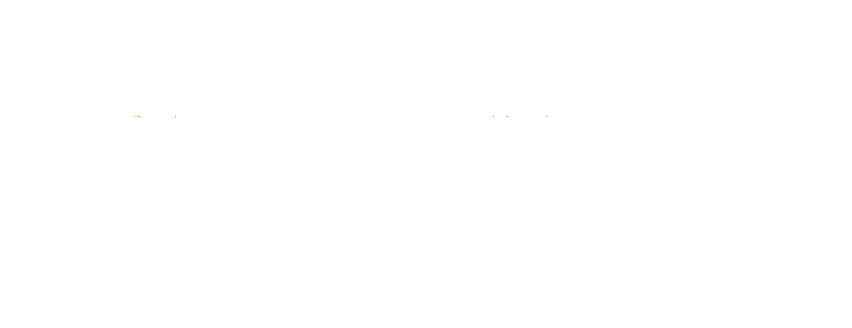

In [34]:
# Ejemplo de uso

#from KFoldCNNTesterDoc import KFoldCNNTester
#from tensorflow.keras.layers import MaxPool2D
# Ejemplo de uso

tester = KFoldCNNTester(data_dict_loaded, 'results', batch_size=1, loading_method='normal', num_folds=5, model_type='LuisFelipe', image_size=(293, 792), max_segment_length=5)
spectrograms = tester.generate_spectrogram_image("F:\\Github\\Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search\\D3T3C\\D3TEC Dataset\\SM-27\\153.wav")
# Mostrar el primer espectrograma generado
if spectrograms:
    plt.figure(figsize=(12, 4))
    plt.imshow(spectrograms[0])
    plt.axis('off')  # Ocultar los ejes
    plt.show()


In [8]:
tester.run_kfold_test()

Starting from fold 1 out of 5, epoch 0
------------------------------------------------------------------------
Training for fold 1 of 5 folds...
Training epoch 1/100, steps per epoch: 49


Training fold 1, epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]c:\Users\herna\anaconda3\envs\tf\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
tester = KFoldCNNTester(data_dict_loaded, 'results', batch_size=1, use_tf_data=True, num_folds = 10, model_type='LuisFelipe') #32 needs supervision as it stops more

# Run the K-Fold test
tester.run_kfold_test()

In [ ]:
# self, data_dict, filename, batch_size=1, use_dummy_data=False, use_tf_data=True, model_type='SpectroCNN', num_channels=3, recording_device='sm', num_folds_range=[5, 8, 10], use_gender='All'):
tester = KFoldCNNTester(data_dict_loaded, 'results', batch_size=1, use_tf_data=True, model_type='SpectroCNN', num_folds=5, use_gender='Female') #32 needs supervision as it stops more

# Run the K-Fold test
tester.run_kfold_test()# self, data_dict, filename, batch_size=1, use_dummy_data=False, use_tf_data=True, model_type='SpectroCNN', num_channels=3, recording_device='sm', num_folds_range=[5, 8, 10], use_gender='All'):


tester = KFoldCNNTester(data_dict_loaded, 'results', batch_size=1, use_tf_data=True, model_type='SpectroCNN', num_folds=10, use_gender='Female') #32 needs supervision as it stops more

# Run the K-Fold test
tester.run_kfold_test()



In [ ]:
# self, data_dict, filename, batch_size=1, use_dummy_data=False, use_tf_data=True, model_type='SpectroCNN', num_channels=3, recording_device='sm', num_folds_range=[5, 8, 10], use_gender='All'):
tester = KFoldCNNTester(data_dict_loaded, 'results', batch_size=1, use_tf_data=True, model_type='SpectroCNN', num_folds=5, use_gender='Male') #32 needs supervision as it stops more

# Run the K-Fold test
tester.run_kfold_test()

In [ ]:
# self, data_dict, filename, batch_size=1, use_dummy_data=False, use_tf_data=True, model_type='SpectroCNN', num_channels=3, recording_device='sm', num_folds_range=[5, 8, 10], use_gender='All'):
tester = KFoldCNNTester(data_dict_loaded, 'results', batch_size=1, use_tf_data=True, model_type='SpectroCNN', num_folds=10, use_gender='Male') #32 needs supervision as it stops more

# Run the K-Fold test
tester.run_kfold_test()